In [2]:
!pip freeze > requirements.txt # Save the requirements in a file for jpyyer notebook

zsh:1: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/ReProduceProject/bioEnv/bin/pip: bad interpreter: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/project/bioEnv/bin/python3.11: no such file or directory


In [15]:
%pip install matplotlib # Install matplotlib for jupyter notebook



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [102]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score,roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
import json


In [81]:
# Function to create a time-series for a single column of data
def create_time_series(single_col, num_splits, time_lag, max_lag):
    segment_length = len(single_col) // num_splits
    time_series = []
    for index in range(num_splits):
        # Extract a segment of the data with a time lag
        segment = single_col[index*segment_length+time_lag : segment_length+index*segment_length+time_lag-max_lag]
        # Append the segment to the time series
        time_series.extend(segment)
    return pd.Series(time_series)


# Function to preprocess the gene expression data
def preprocess_expression_data(expression_matrix, num_splits, max_lag):
    new_columns = []
    for gene_name in expression_matrix.columns:
        for lag_index in range(max_lag):
            # Create a time-series for each gene
            new_column = create_time_series(expression_matrix[gene_name], num_splits, lag_index, max_lag)
            new_column.name = gene_name + '_' + str(max_lag-lag_index)
            new_columns.append(new_column)
    # Concatenate all new columns into a DataFrame
    preprocessed_data = pd.concat(new_columns, axis=1)
    return preprocessed_data


In [109]:
# Main function to run the BiXGBoost algorithm
def run_BiXGBoost(expression_file, num_samples, output_file):
    # Read the gene expression data from a file
    gene_expression_data = pd.read_csv(expression_file,  sep='\t')
    scores = {}
    # Initialize lists to store the AUROC and AUPR for each gene
    auroc_scores_in = []
    aupr_scores_in = []
    auroc_scores_out = []
    aupr_scores_out = []
    # Loop over each gene in the data
    for index in range(len(gene_expression_data.columns)):
        # Copy the gene expression data
        copied_data = gene_expression_data.copy()
        
        # Create a time-series for the target gene
        target_gene_series_in = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 2, 2)
        
        # Normalize the target gene data
        normalized_target_gene_in = (target_gene_series_in - target_gene_series_in.mean()) / target_gene_series_in.std()

        # Create a time-series for the target gene for local-out model
        target_gene_series_out = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 0, 2)
        
        # Normalize the target gene data for local-out model
        normalized_target_gene_out = (target_gene_series_out - target_gene_series_out.mean()) / target_gene_series_out.std()
        
        # Preprocess the gene expression data
        preprocessed_data_in = preprocess_expression_data(copied_data, num_samples, 2)
        
        preprocessed_data_out = preprocess_expression_data(copied_data, num_samples, 2)
        # Create and train an XGBoost model
        xgboost_model_in = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
        
        xgboost_model_in.fit(preprocessed_data_in, normalized_target_gene_in)
        
        # Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
        predictions_in = xgboost_model_in.predict(preprocessed_data_in)
        mse = mean_squared_error(predictions_in, normalized_target_gene_in)
        rmse = sqrt(mse)
        r2 = r2_score(normalized_target_gene_in, predictions_in)

        # Create and train an XGBoost model for local-out model
        xgboost_model_out = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
        xgboost_model_out.fit(preprocessed_data_out, normalized_target_gene_out)
        
        predictions_out = xgboost_model_out.predict(preprocessed_data_out)
        mse_out = mean_squared_error(predictions_out, normalized_target_gene_out)
        rmse_out = sqrt(mse_out)
        r2_out = r2_score(normalized_target_gene_out, predictions_out)
        
        # Calculate the correlation between the predictions of the local-in and local-out models
        correlation = np.corrcoef(predictions_in, predictions_out)[0, 1]
        print("here the correlation is: ", correlation)
        
        # Binarize the labels for local in
        normalized_target_gene_in_binary_in = (normalized_target_gene_in > 0.5).astype(int)
        # Binarize the labels for local out
        normalized_target_gene_out_binary_out = (normalized_target_gene_out > 0.5).astype(int)

        # Calculate AUROC and AUPR for local_in
        auroc_in = roc_auc_score(normalized_target_gene_in_binary_in, predictions_in)
        aupr_in = average_precision_score(normalized_target_gene_in_binary_in, predictions_in)
        # Calculate AUROC and AUPR for local_out
        auroc_out = roc_auc_score(normalized_target_gene_out_binary_out, predictions_out)
        aupr_out = average_precision_score(normalized_target_gene_out_binary_out, predictions_out)
        print("auroc in:",gene_expression_data.columns[index], auroc_in)
        print("aupr in:",gene_expression_data.columns[index], aupr_in)
        print("auroc out:",gene_expression_data.columns[index], auroc_out)
        print("aupr out:",gene_expression_data.columns[index], aupr_out)

        # If the correlation is greater than 0.5, store the scores for both models. Otherwise, store the scores for the local-in model only.
        if correlation > 0.5:
            scores[gene_expression_data.columns[index]] = {
                'In Model': {'MSE': mse, 'RMSE': rmse, 'R2': r2},
                'Out Model': {'MSE': mse_out, 'RMSE': rmse_out, 'R2': r2_out}
            }
        else:
            scores[gene_expression_data.columns[index]] = {
                'In Model': {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'AUROC_IN': auroc_in, 'AUPR_IN': aupr_in,'AUROC_OUT': auroc_out, 'AUPR_out': aupr_out}
            }
        print('XGBoost: ',gene_expression_data.columns[index], mse, rmse, r2)
        # Add the scores to the lists for local-in model
        auroc_scores_in.append(auroc_in)
        aupr_scores_in.append(aupr_in)
        # Add the scores to the lists for local-out model
        auroc_scores_out.append(auroc_out)
        aupr_scores_out.append(aupr_out)
        
    average_auroc_in = np.mean(auroc_scores_in)
    average_aupr_in = np.mean(aupr_scores_in)
    average_auroc_out = np.mean(auroc_scores_out)
    average_aupr_out = np.mean(aupr_scores_out)

    print('Average AUROC_IN: ', average_auroc_in)
    print('Average AUPR_IN: ', average_aupr_in)
    print('Average AUROC_OUT: ', average_auroc_out)
    print('Average AUPR_OUT: ', average_aupr_out)
    # Write the average AUROC_IN and AUPR_IN to a file
    with open('average_scores_in.txt', 'w') as f:
        f.write('Average AUROC_IN: ' + str(average_auroc_in) + '\n')
        f.write('Average AUPR_IN: ' + str(average_aupr_in) + '\n')
    # Write the average AUROC_OUT and AUPR_OUT to a file
    with open('average_scores_out.txt', 'w') as f:
        f.write('Average AUROC_OUT: ' + str(average_auroc_out) + '\n')
        f.write('Average AUPR_OUT: ' + str(average_aupr_out) + '\n')


    # Save the scores to a file
    # with open(output_file, 'w') as f:
    #     for gene, metrics in scores.items():
    #         f.write(f"{gene}: {metrics}\n")

    # Write the scores to a JSON file
    with open(output_file, 'w') as f:
        json.dump(scores, f)

    return scores

In [80]:
# def run_RandomForest(expression_file, num_samples, output_file):
#     # Read the gene expression data from a file
#     gene_expression_data = pd.read_csv(expression_file, sep='\t')
    
#     # Create a time-series for the target gene for local-in model
#     target_gene_series_in = create_time_series(gene_expression_data, num_samples, 2, 2)
    
#     # Normalize the target gene data for local-in model
#     normalized_target_gene_in = (target_gene_series_in - target_gene_series_in.mean()) / target_gene_series_in.std()
    
#     # Create a time-series for the target gene for local-out model
#     target_gene_series_out = create_time_series(gene_expression_data, num_samples, 0, 2)
    
#     # Normalize the target gene data for local-out model
#     normalized_target_gene_out = (target_gene_series_out - target_gene_series_out.mean()) / target_gene_series_out.std()
    
#     # Preprocess the gene expression data for local-in and local-out models
#     preprocessed_data_in = preprocess_expression_data(gene_expression_data, num_samples, 2)
#     preprocessed_data_out = preprocess_expression_data(gene_expression_data, num_samples, 2)
    
#     # Create the RandomForestRegressor objects
#     random_forest_in = RandomForestRegressor(n_estimators=1000, random_state=42)
#     random_forest_out = RandomForestRegressor(n_estimators=1000, random_state=42)
    
#     scores = {}
    
#     # Loop over each gene in the data
#     for index, gene_name in enumerate(gene_expression_data.columns):
#         # Train the RandomForestRegressor for local-in model
#         random_forest_in.fit(preprocessed_data_in, normalized_target_gene_in)
        
#         # Train the RandomForestRegressor for local-out model
#         random_forest_out.fit(preprocessed_data_out, normalized_target_gene_out)
        
#         # Evaluate the models using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
#         predictions_in = random_forest_in.predict(preprocessed_data_in)
#         mse_in = mean_squared_error(predictions_in, normalized_target_gene_in)
#         rmse_in = sqrt(mse_in)
#         r2_in = r2_score(normalized_target_gene_in, predictions_in)
        
#         predictions_out = random_forest_out.predict(preprocessed_data_out)
#         mse_out = mean_squared_error(predictions_out, normalized_target_gene_out)
#         rmse_out = sqrt(mse_out)
#         r2_out = r2_score(normalized_target_gene_out, predictions_out)
        
#         # Calculate the correlation between the predictions of the local-in and local-out models
#         correlation = np.corrcoef(predictions_in, predictions_out)[0, 1]

#         # Add AUROC and AUPR to the scores dictionary
#         scores[gene_expression_data.columns[index]] = {
#             'In Model': {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'AUROC': auroc, 'AUPR': aupr}
#         }
        
#         # If the correlation is greater than 0.5, store the scores for both models. Otherwise, store the scores for the local-in model only.
#         if correlation > 0.5:
#             scores[gene_name] = {
#                 'In Model': {'MSE': mse_in, 'RMSE': rmse_in, 'R2': r2_in},
#                 'Out Model': {'MSE': mse_out, 'RMSE': rmse_out, 'R2': r2_out}
#             }
#         else:
#          scores[gene_name] = {
#          'In Model': {'MSE': mse_in, 'RMSE': rmse_in, 'R2': r2_in}
#         }



In [78]:
# Run the BiXGBoost function
# run_BiXGBoost('data/DREAM100/insilico_size100_1_timeseries.txt', 10, 'BiXGBoost_scores_output.json')



190
190
Skipping G1 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G2 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G3 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G4 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G5 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G6 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G7 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G8 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G9 due to mismatched dimensions in the preprocessed data and labels for local-out model.
190
190
Skipping G10 due to mismatched dimensi

{}

In [110]:
# Run the BiXGBoost function
run_BiXGBoost('data/DREAM100/insilico_size100_1_timeseries.txt', 10, 'BiXGBoost_scores_output.json')

here the correlation is:  0.7559580274738926
auroc in: G1 0.9885730211817169
aupr in: G1 0.9708183732296095
auroc out: G1 1.0
aupr out: G1 1.0
XGBoost:  G1 1.052478550122714 1.0259037723503672 -0.05804721970008275
here the correlation is:  0.6397457212049695
auroc in: G2 0.9378019323671498
aupr in: G2 0.8549400853916985
auroc out: G2 1.0
aupr out: G2 1.0000000000000002
XGBoost:  G2 1.101985148722218 1.0497548040958031 -0.10781575797471654
here the correlation is:  0.3981244088769074
auroc in: G3 0.8656045751633986
aupr in: G3 0.7656711199704304
auroc out: G3 1.0
aupr out: G3 1.0
XGBoost:  G3 1.130180040818424 1.0630992619781203 -0.1361598293941828
here the correlation is:  0.7340101514346585
auroc in: G4 0.9450604838709677
aupr in: G4 0.8995446126220481
auroc out: G4 0.9998109879032258
aupr out: G4 0.9992555831265507
XGBoost:  G4 1.0798338107971073 1.0391505236476124 -0.08554721720344127
here the correlation is:  0.7322607251040404
auroc in: G5 0.9152207645648187
aupr in: G5 0.83164745

{'G1': {'In Model': {'MSE': 1.052478550122714,
   'RMSE': 1.0259037723503672,
   'R2': -0.05804721970008275},
  'Out Model': {'MSE': 1.0338159921093981,
   'RMSE': 1.0167674228206753,
   'R2': -0.039285917993574504}},
 'G2': {'In Model': {'MSE': 1.101985148722218,
   'RMSE': 1.0497548040958031,
   'R2': -0.10781575797471654},
  'Out Model': {'MSE': 1.0395806768317886,
   'RMSE': 1.0195982918933262,
   'R2': -0.045081103693332514}},
 'G3': {'In Model': {'MSE': 1.130180040818424,
   'RMSE': 1.0630992619781203,
   'R2': -0.1361598293941828,
   'AUROC_IN': 0.8656045751633986,
   'AUPR_IN': 0.7656711199704304,
   'AUROC_OUT': 1.0,
   'AUPR_out': 1.0}},
 'G4': {'In Model': {'MSE': 1.0798338107971073,
   'RMSE': 1.0391505236476124,
   'R2': -0.08554721720344127},
  'Out Model': {'MSE': 1.0381600864082583,
   'RMSE': 1.0189014115253048,
   'R2': -0.04365299691835478}},
 'G5': {'In Model': {'MSE': 1.0756625616219888,
   'RMSE': 1.0371415340357308,
   'R2': -0.08135389792686731},
  'Out Model': 

In [85]:
# Run the RandomForest function
# run_RandomForest('data/DREAM100/insilico_size100_1_timeseries.txt', 10,'BiRandomForest_scores_output.json')

RandomForest In Model:  G1 0.025650816145677102 0.16015872172840637 0.9742134652503776
RandomForest Out Model:  G1 0.0015200912156218306 0.03898834717735327 0.9984718659737135
RandomForest In Model:  G2 0.0756466954770133 0.2750394434931348 0.9239530574569708
RandomForest Out Model:  G2 0.0023161433450370615 0.04812632694313022 0.9976716019282696
RandomForest In Model:  G3 0.11691053685173242 0.3419218285686546 0.8824708888792108
RandomForest Out Model:  G3 0.0024087782411228195 0.049079305629998675 0.9975784769004585
RandomForest In Model:  G4 0.04382439694969522 0.20934277381771557 0.9559437279341688
RandomForest Out Model:  G4 0.0010749550008482957 0.03278650638369839 0.9989193574065546
RandomForest In Model:  G5 0.04678355520596609 0.21629506514473715 0.9529689127559071
RandomForest Out Model:  G5 0.0016617608947712475 0.04076470157834162 0.9983294467195422
RandomForest In Model:  G6 0.07489090813581444 0.27366203268961964 0.9247128436729908
RandomForest Out Model:  G6 0.0076458036

{'G1': {'In Model': {'MSE': 0.025650816145677102,
   'RMSE': 0.16015872172840637,
   'R2': 0.9742134652503776},
  'Out Model': {'MSE': 0.0015200912156218306,
   'RMSE': 0.03898834717735327,
   'R2': 0.9984718659737135}},
 'G2': {'In Model': {'MSE': 0.0756466954770133,
   'RMSE': 0.2750394434931348,
   'R2': 0.9239530574569708},
  'Out Model': {'MSE': 0.0023161433450370615,
   'RMSE': 0.04812632694313022,
   'R2': 0.9976716019282696}},
 'G3': {'In Model': {'MSE': 0.11691053685173242,
   'RMSE': 0.3419218285686546,
   'R2': 0.8824708888792108}},
 'G4': {'In Model': {'MSE': 0.04382439694969522,
   'RMSE': 0.20934277381771557,
   'R2': 0.9559437279341688},
  'Out Model': {'MSE': 0.0010749550008482957,
   'RMSE': 0.03278650638369839,
   'R2': 0.9989193574065546}},
 'G5': {'In Model': {'MSE': 0.04678355520596609,
   'RMSE': 0.21629506514473715,
   'R2': 0.9529689127559071},
  'Out Model': {'MSE': 0.0016617608947712475,
   'RMSE': 0.04076470157834162,
   'R2': 0.9983294467195422}},
 'G6': {'I

In [11]:
# Function to read scores from a file
def read_scores(file_name):
    with open(file_name, 'r') as f:
        scores = json.load(f)
    return scores

In [32]:
# def visualize_scores_without_grouped_genes():
#     # Read the scores
#     xgboost_scores = read_scores('BiXGBoost_scores_output.json')
#     random_forest_scores = read_scores('BiRandomForest_scores_output.json')
    
#     # Get the gene names from the keys of the dictionaries
#     genes = list(xgboost_scores.keys())
    
#     metrics = ['MSE', 'RMSE', 'R2']
    
#     for metric in metrics:
#         fig, ax = plt.subplots()
    
#         # Set the figure size
#         fig.set_size_inches(20, 10)  # Increase the size of the figure
    
#         # Set the position of the bars on the x-axis
#         bar_width = 0.35
#         r1 = np.arange(len(genes))  # the label locations
#         r2 = [x + bar_width for x in r1]
    
#         # Make the plot
#         rects1 = ax.bar(r1, [xgboost_scores[gene][metric] for gene in genes], bar_width, label='XGBoost')
#         rects2 = ax.bar(r2, [random_forest_scores[gene][metric] for gene in genes], bar_width, label='Random Forest')
    
#         # Add some text for labels, title and custom x-axis tick labels, etc.
#         ax.set_xlabel('Genes')
#         ax.set_ylabel(metric.upper() + ' Scores')
#         ax.set_title(metric.upper() + ' Scores by Genes and Models')
#         ax.set_xticks([r + bar_width / 2 for r in range(len(genes))])
#         ax.set_xticklabels(genes, rotation=45)  # Rotate the labels
#         ax.legend()
    
#         # Show the plot
#         plt.show()

In [12]:
def visualize_scores_with_grouped_genes():
    # Read the scores from the output files
    xgboost_scores = read_scores('BiXGBoost_scores_output.json')
    random_forest_scores = read_scores('BiRandomForest_scores_output.json')
    
    # Extract the gene names from the keys of the score dictionaries
    all_genes = list(xgboost_scores.keys())
    
    # Define the metrics we're interested in
    metrics_to_plot = ['MSE', 'RMSE', 'R2']
    
    # Group the genes into groups of 10
    gene_groups = [all_genes[i:i + 10] for i in range(0, len(all_genes), 10)]
    gene_group_labels = ['G' + str(i*10+1) + '-G' + str((i+1)*10) for i in range(len(gene_groups))]
    
    for metric in metrics_to_plot:
        fig, ax = plt.subplots()
    
        # Set the figure size
        fig.set_size_inches(20, 10)
    
        # Set the position of the bars on the x-axis
        bar_width = 0.35
        bar_positions_xgboost_in = np.arange(len(gene_group_labels))
        bar_positions_xgboost_out = [x + bar_width for x in bar_positions_xgboost_in]
        bar_positions_random_forest_in = [x + 2*bar_width for x in bar_positions_xgboost_in]
        bar_positions_random_forest_out = [x + 3*bar_width for x in bar_positions_xgboost_in]
    
        # Calculate the average scores for each group of genes
        avg_scores_xgboost_in = [np.mean([xgboost_scores[gene]['In Model'][metric] for gene in gene_group]) for gene_group in gene_groups]
        avg_scores_xgboost_out = [np.mean([xgboost_scores[gene]['Out Model'][metric] for gene in gene_group]) for gene_group in gene_groups]
        avg_scores_random_forest_in = [np.mean([random_forest_scores[gene]['In Model'][metric] for gene in gene_group]) for gene_group in gene_groups]
        avg_scores_random_forest_out = [np.mean([random_forest_scores[gene]['Out Model'][metric] for gene in gene_group]) for gene_group in gene_groups]
    
        # Plot the bars for each model
        ax.bar(bar_positions_xgboost_in, avg_scores_xgboost_in, bar_width, label='XGBoost In Model')
        ax.bar(bar_positions_xgboost_out, avg_scores_xgboost_out, bar_width, label='XGBoost Out Model')
        ax.bar(bar_positions_random_forest_in, avg_scores_random_forest_in, bar_width, label='Random Forest In Model')
        ax.bar(bar_positions_random_forest_out, avg_scores_random_forest_out, bar_width, label='Random Forest Out Model')
    
        ax.set_xlabel('Gene Groups')
        ax.set_ylabel(metric.upper() + ' Scores')
        ax.set_title(metric.upper() + ' Scores by Gene Groups and Models')
        ax.set_xticks([r + 2*bar_width for r in range(len(gene_group_labels))])
        ax.set_xticklabels(gene_group_labels, rotation=45)
        ax.legend()
    
        plt.show()


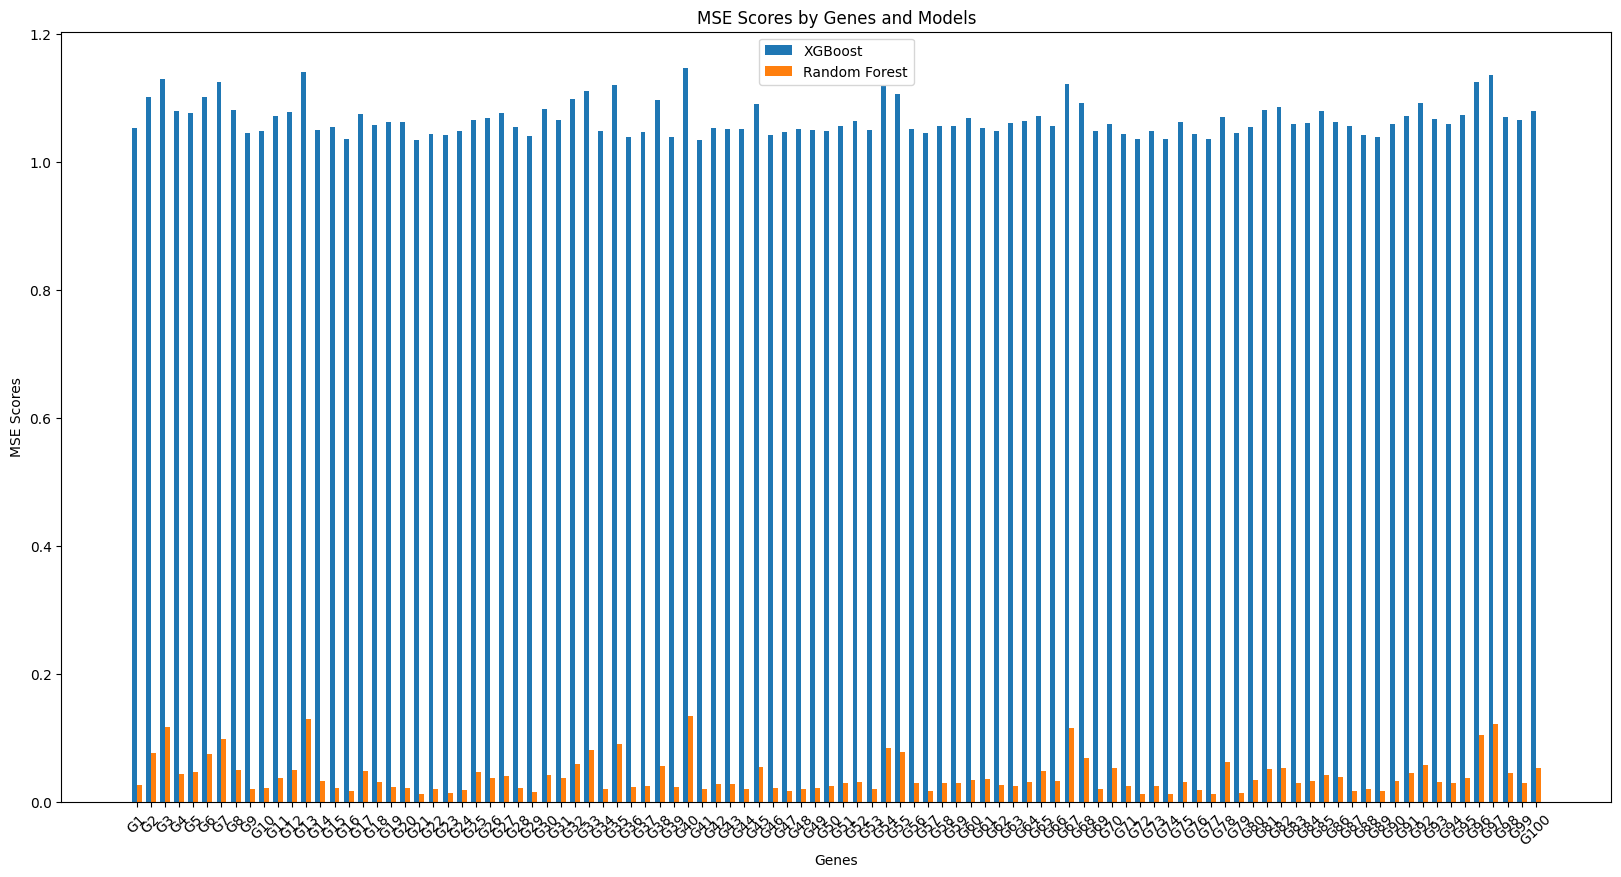

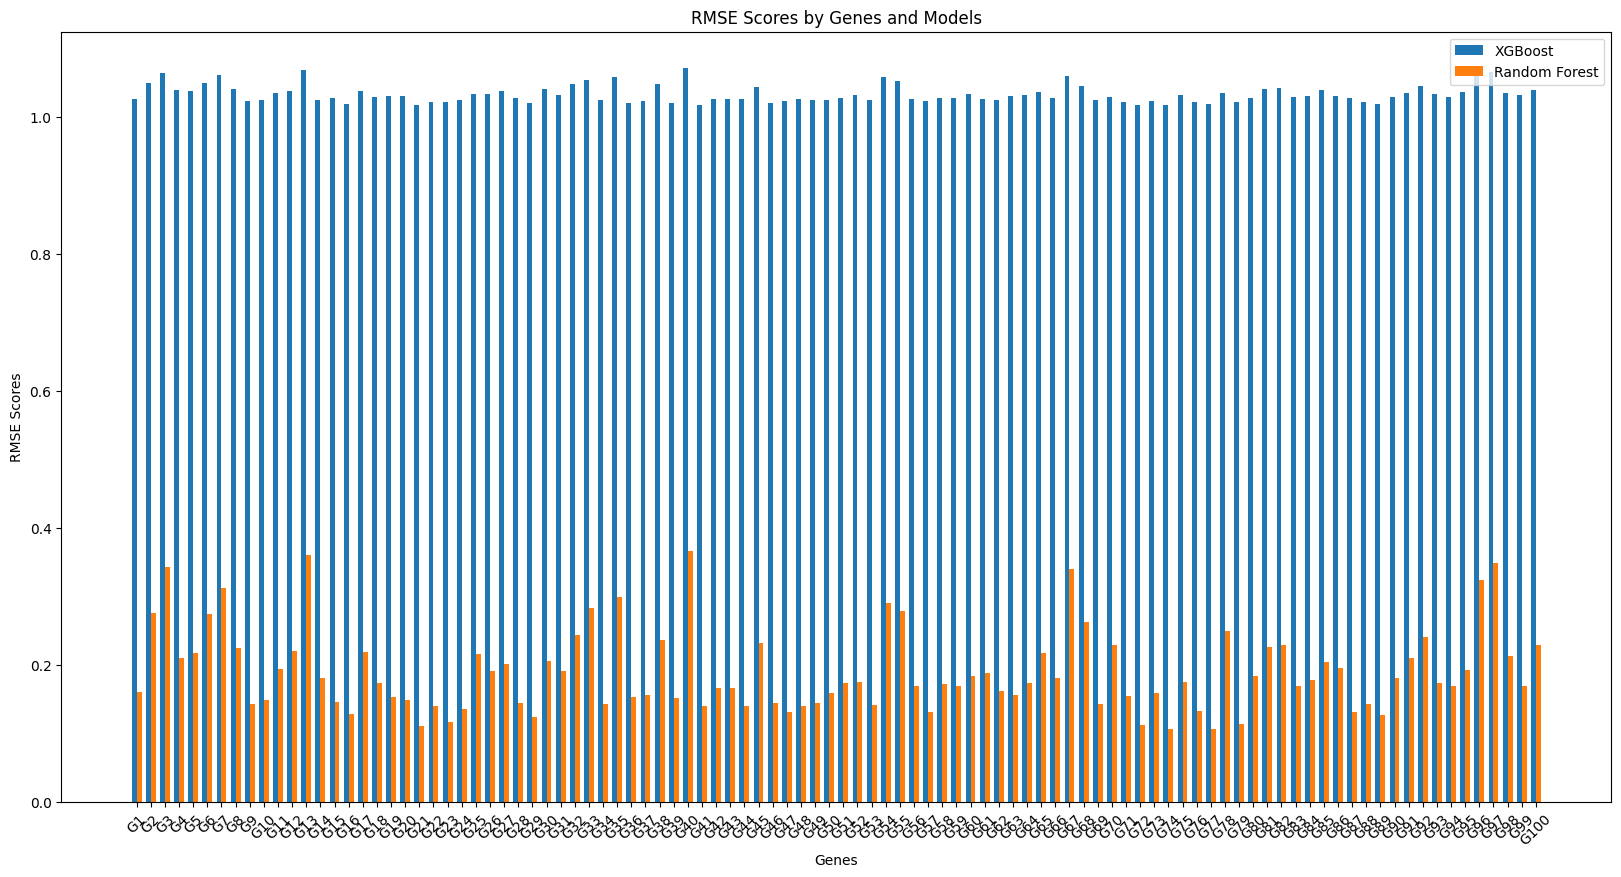

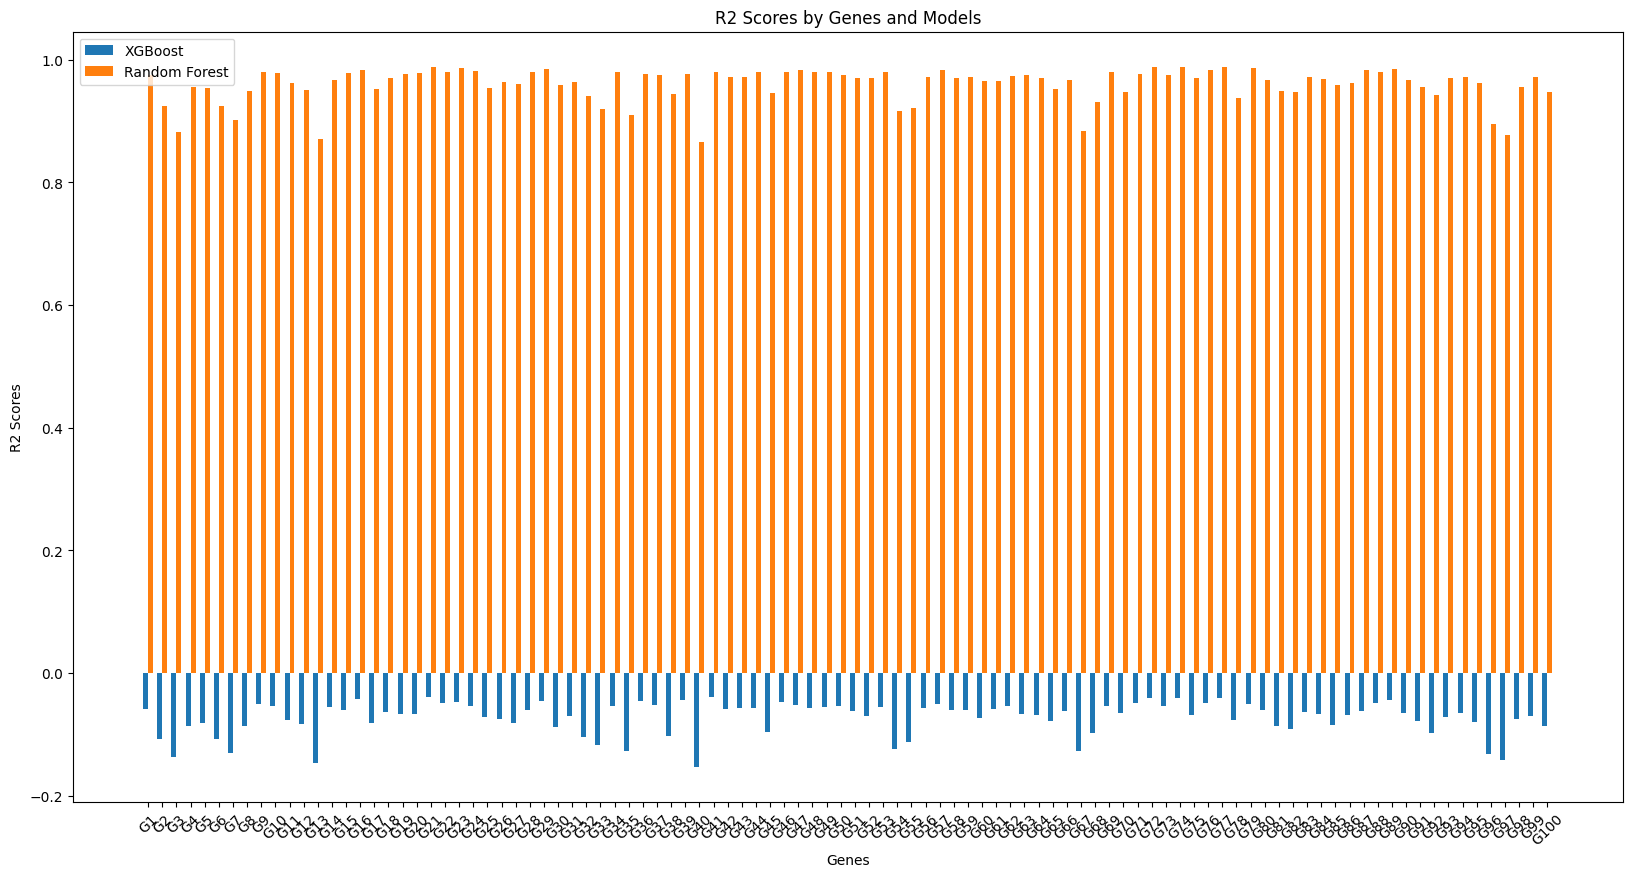

In [33]:
# visualize_scores_without_grouped_genes()

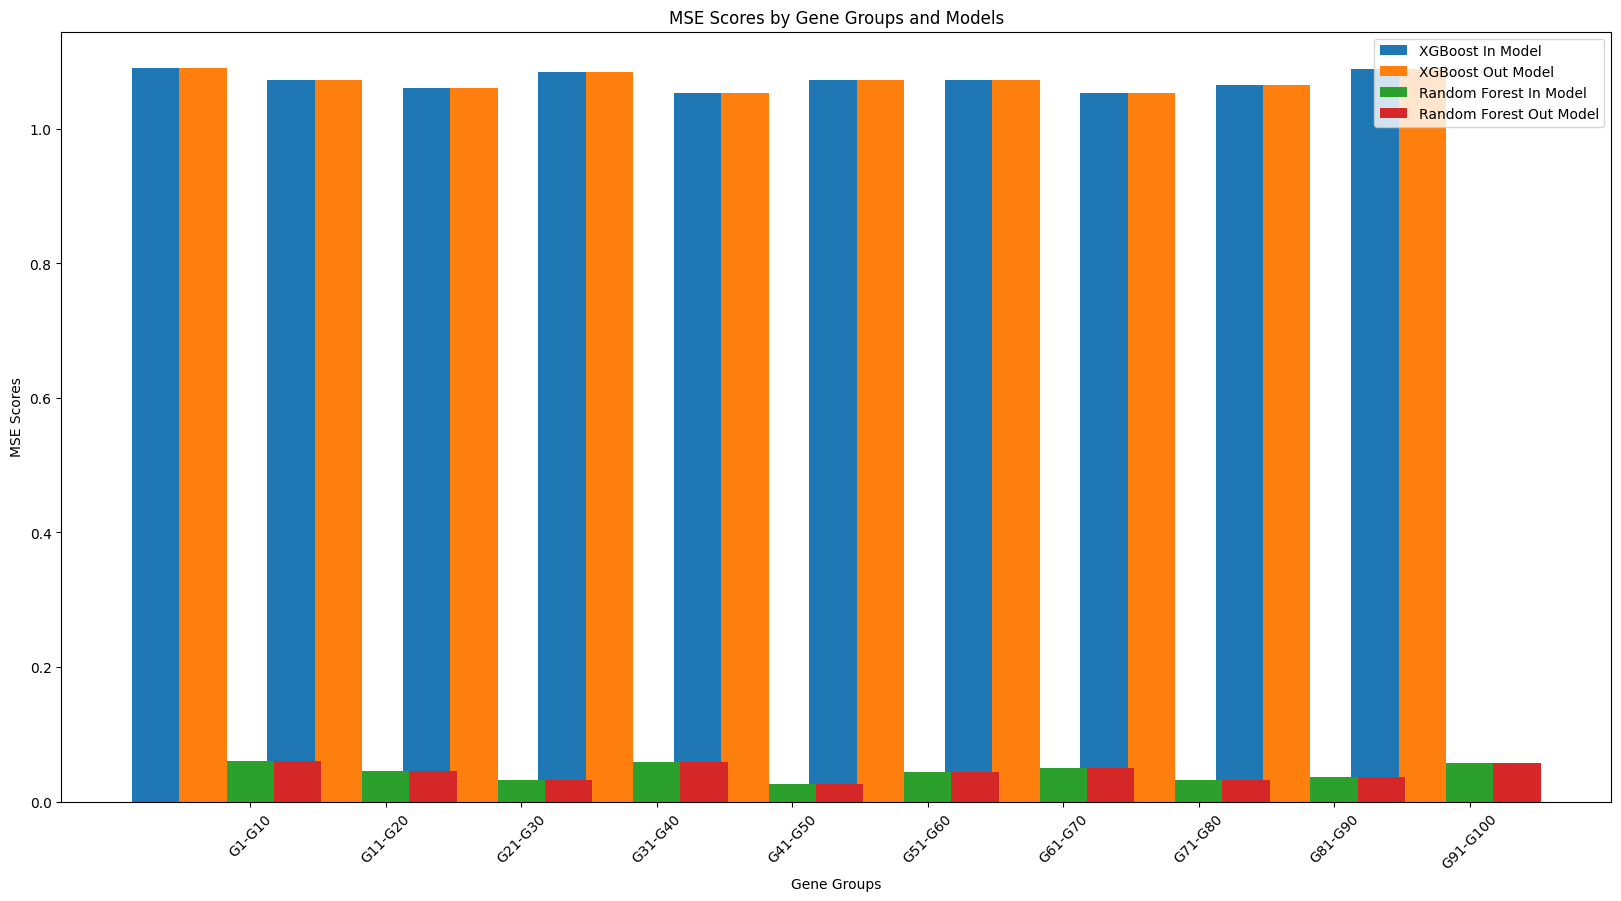

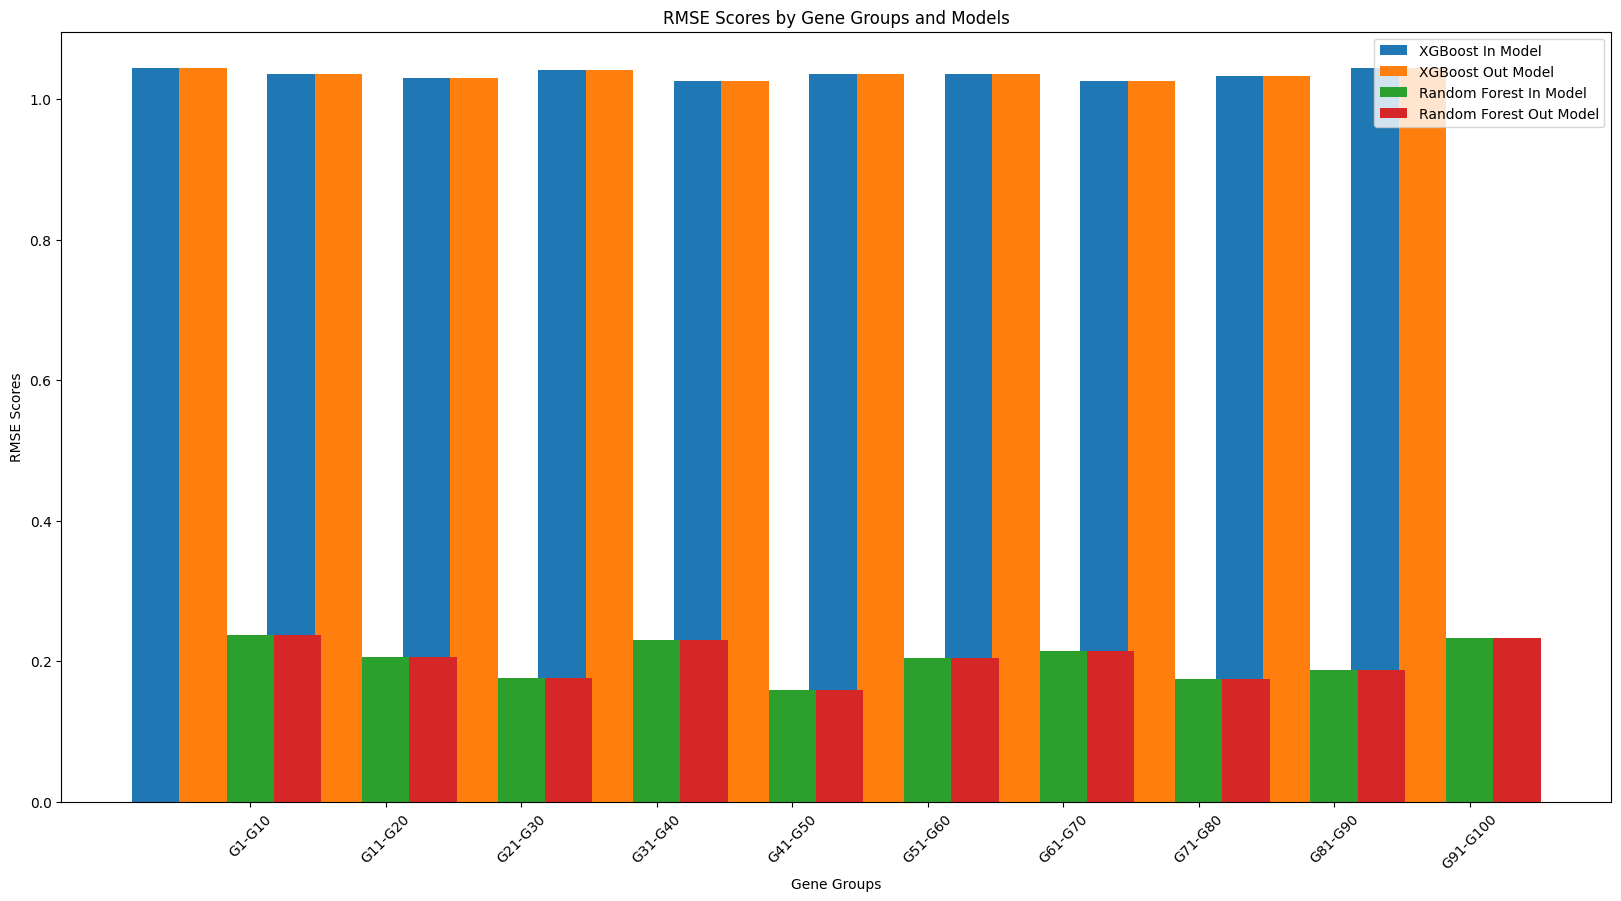

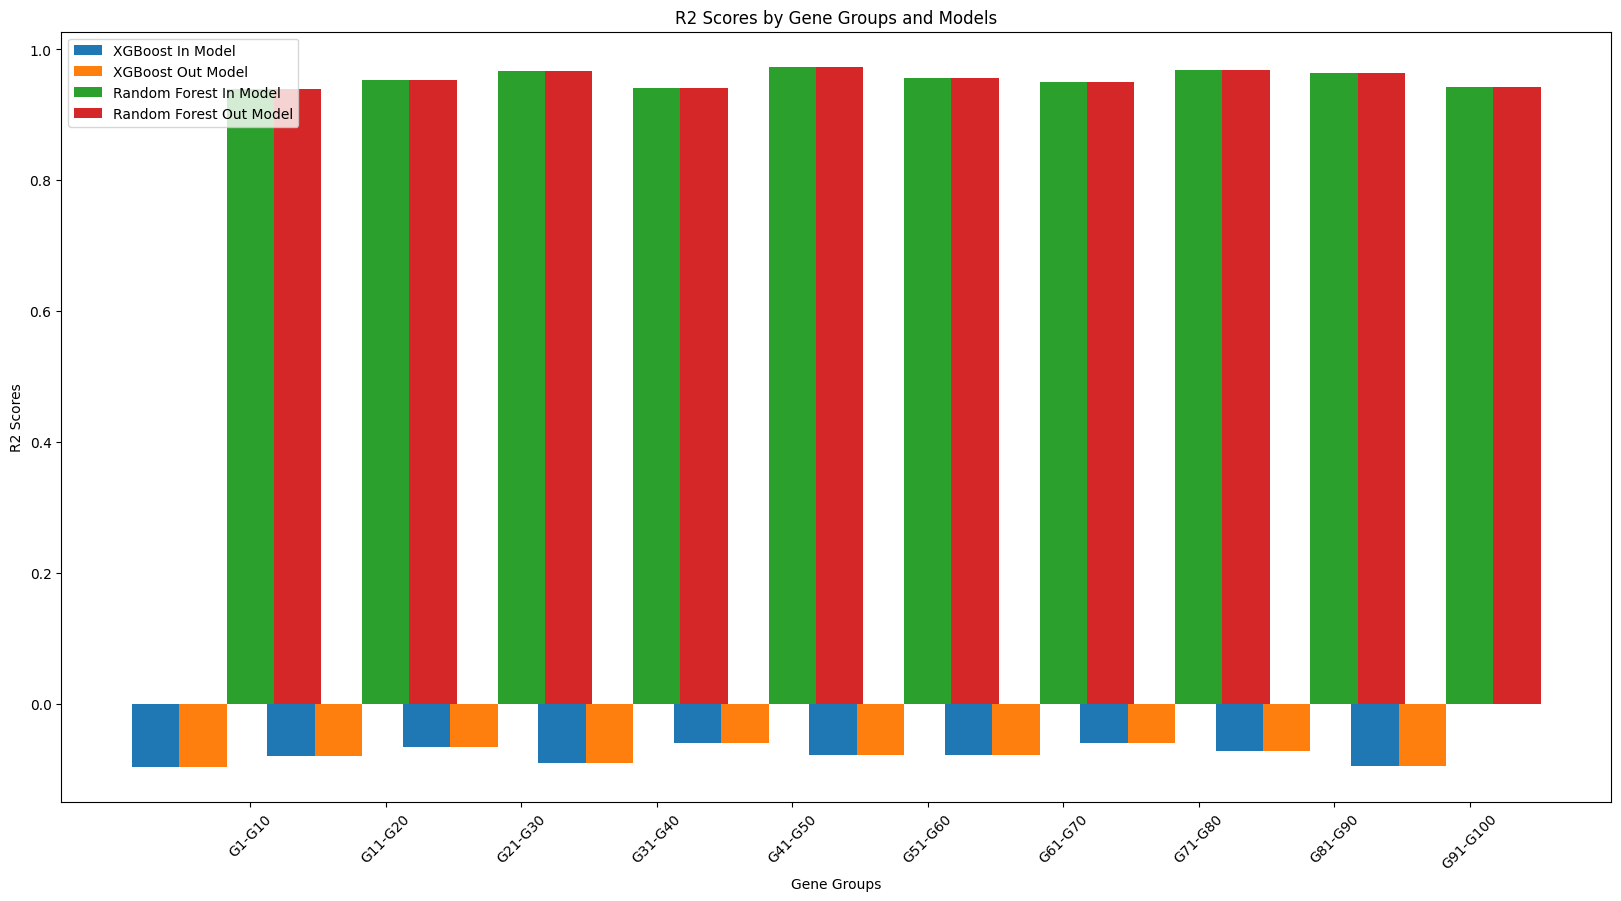

In [13]:
visualize_scores_with_grouped_genes()